In [1]:
import boto3
import pandas as pd
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)


manifolddata


In [2]:
client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,label,attackType,attackID,attackDescription
0,2017-08-02 00:00:00.419,0.003,TCP,192.168.210.55,44870,192.168.100.11,445.0,2,174,1,.AP...,0,normal,---,---,---
1,2017-08-02 00:00:00.421,0.000,TCP,192.168.100.11,445,192.168.210.55,44870.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-08-02 00:00:02.593,0.004,TCP,192.168.220.47,55101,192.168.100.11,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-08-02 00:00:02.859,0.000,TCP,10000_34,443,192.168.210.54,59628.0,1,100,1,.AP...,0,normal,---,---,---
4,2017-08-02 00:00:02.594,0.000,TCP,192.168.100.11,445,192.168.220.47,55101.0,1,108,1,.AP...,0,normal,---,---,---


In [4]:
### Data exploration
df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']

In [5]:
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

In [6]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02


In [7]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])

In [8]:
#xport dataframe for other use

#df.to_csv('week1processed.csv')

In [9]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)"
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)"
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)"
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)"
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)"


How many unique IP addreses are there?

In [22]:
df['Dst_IP'].nunique()

9343

How many unique pairs of IP addresses are there in the entire dataset?

In [10]:
df['pairs2'].nunique()

44751

How often does each pair occur in the entire datast?

In [11]:
pairs_count=df.groupby(['pairs2'], as_index=False)['Date'].count()
pairs_count.columns=['pairs','count']

Text(0.5,0,'Number of times IP pair is repeated')

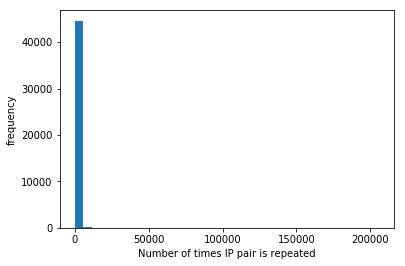

In [12]:
plt.hist(pairs_count['count'], bins=35)
plt.ylabel('frequency')
plt.xlabel('Number of times IP pair is repeated')

Group the data by the hour timestep, count how many times each pair occurs in that hour

In [25]:
hour_group=df.groupby(['date_hr', 'pairs2'], as_index=False)['Date'].count()
hour_group.columns=[['date_hr', 'pairs', 'count']]

In [33]:
hour_group.head(5)

,date_hr,pairs,count
0,2017-08-02,"(10000_34, 192.168.210.54)",6
1,2017-08-02,"(10001_213, 192.168.210.54)",53
2,2017-08-02,"(10002_162, 192.168.210.57)",10
3,2017-08-02,"(10002_174, 192.168.210.54)",20
4,2017-08-02,"(10002_174, 192.168.210.57)",30


Group the data by hour timestep, count how many unique pairs occur in that hour

In [15]:
hour_group2=df.groupby(['date_hr', 'pairs2'], as_index=False)['Date'].count()
hour_group_distinct_pairs=hour_group2.groupby(['date_hr'], as_index=False)['pairs2'].count()


In [16]:
hour_group_distinct_pairs.head()

,date_hr,pairs2
0,2017-08-02 00:00:00,85
1,2017-08-02 01:00:00,113
2,2017-08-02 02:00:00,99
3,2017-08-02 03:00:00,101
4,2017-08-02 04:00:00,111


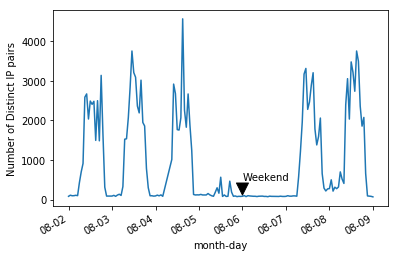

In [21]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
ax.plot(hour_group_distinct_pairs['date_hr'], hour_group_distinct_pairs['pairs2'])

myFmt = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(myFmt)
ax.annotate('Weekend', xy=('2017-8-6', 100), xytext=('2017-8-6', 500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Number of Distinct IP pairs')
plt.xlabel('month-day')
plt.show()

How many rows are in 1 day of data?

In [19]:
df

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)"
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)"
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)"
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)"
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)"
5,2017-08-02 00:00:02.847,0.210,192.168.210.54,59628,10000_34,443.0,2,154,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)"
6,2017-08-02 00:00:03.568,0.000,192.168.100.11,445,192.168.220.42,58001.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.42]","(192.168.100.11, 192.168.220.42)"
7,2017-08-02 00:00:03.567,0.002,192.168.220.42,58001,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.42]","(192.168.100.11, 192.168.220.42)"
8,2017-08-02 00:00:04.193,0.000,192.168.100.11,445,192.168.220.46,49770.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.46]","(192.168.100.11, 192.168.220.46)"
9,2017-08-02 00:00:04.192,0.001,192.168.220.46,49770,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.46]","(192.168.100.11, 192.168.220.46)"
